In [1]:
# Header File

from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestRegressor


# inline plotting instead of popping out
%matplotlib inline


/usr/local/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Preprocessing

In [2]:
# Load Data & Data Prepocess
df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=',')

df.head()

df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature
df.head()

idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idx].drop('pm2.5', axis=1)
y = df.loc[idx]['pm2.5'].values

# PCA 
"""
sc = StandardScaler()
Z = sc.fit_transform(X)
print(X.shape[1])
R = np.dot(Z.T, Z) / X.shape[0]
eigen_vals, eigen_vecs = np.linalg.eigh(R)
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)
W_4D = np.hstack((eigen_pairs[0][1][:, np.newaxis],
                  eigen_pairs[1][1][:, np.newaxis],
                  eigen_pairs[2][1][:, np.newaxis],
                  eigen_pairs[3][1][:, np.newaxis]))
Z_pca4 = Z.dot(W_4D)
"""

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=25)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[1])

# Standardization

sc_X = StandardScaler()
sc_X.fit(X_train)
X_train_std = sc_X.transform(X_train)
X_test_std = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
y_test_std = sc_y.transform(y_test[:, np.newaxis]).flatten()

# sc_y = StandardScaler()
# sc_y.fit(y_train[:, np.newaxis])
# y_train_std = sc_y.transform(y_train[:, np.newaxis]).flatten()
# y_test_std = sc_y.transform(y_test[:, np.newaxis]).flatten()


#Training data points: 1491
#Testing data points: 11


# Polynomial Regression

In [3]:
class LinearRegressionGD(object):
    
    def __init__(self, eta=1.0, n_iter=10000, random_state=0):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.eps = 1e-8
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.001, size=1 + X.shape[1])
        self.cost_ = []
        self.l_ = np.zeros(1 + X.shape[1])

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            # print(errors, y, output)
            self.l_[1:] += np.sqrt(X.T.dot(errors)**2)
            self.l_[0] += np.sqrt(errors.sum()**2)
            self.w_[1:] +=  self.eta * X.T.dot(errors) / self.l_[1:]
            self.w_[0] +=  self.eta * errors.sum() / self.l_[0]
            cost = (errors**2).sum() / len(y)
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

MSE train: 0.27, test: 0.29
R^2 train: 0.73, test: 0.73
--- random state 7 test Pass !!! ---


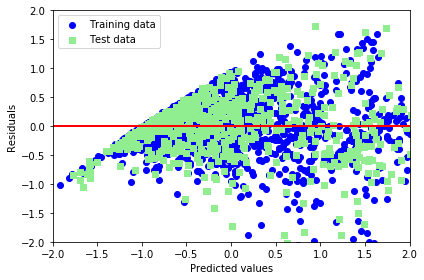

In [14]:

poly = PolynomialFeatures(degree=3)
X_poly_std = poly.fit(X_train_std) 
X_poly_train = X_poly_std.transform(X_train_std)
X_poly_test  = X_poly_std.transform(X_test_std)

poly4Regr = LinearRegressionGD(random_state=7)
poly4Regr.fit(X_poly_train, y_train_std)

poly4Regr_r2 =  r2_score(y_train_std, poly4Regr.predict(X_poly_train))

y_train_pred = poly4Regr.predict(X_poly_train)
y_test_pred = poly4Regr.predict(X_poly_test)

if r2_score(y_test_std, y_test_pred) > 0.71:

    print('MSE train: %.2f, test: %.2f' %
          (mean_squared_error(y_train_std, y_train_pred),
           mean_squared_error(y_test_std, y_test_pred)))
    print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train_std, y_train_pred),
                                           r2_score(y_test_std, y_test_pred)))
    isPass = True
    print('--- random state 7 test Pass !!! ---')
    

plt.scatter(
    y_train_pred,
    y_train_pred - y_train_std,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred,
    y_test_pred - y_test_std,
    c='lightgreen',
    marker='s',
    label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-2, xmax=2, lw=2, color='red')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.tight_layout()
plt.show()

### Random Forest

MSE train: 187.74, test: 1045.70
R^2 train: 0.99, test: 0.94


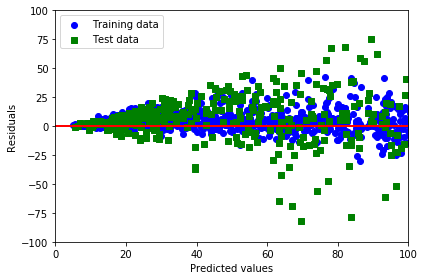

In [5]:
forest = RandomForestRegressor(
    n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train_std, y_train)
y_train_pred = forest.predict(X_train_std)
y_test_pred = forest.predict(X_test_std)

print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

# Residual plot
plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred, y_test_pred - y_test, c='green', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=100, lw=2, color='red')
plt.xlim([0, 100])
plt.ylim([-100, 100])
plt.tight_layout()
plt.show()